In [1]:
import pandas as pd
from collections import Counter
from pathlib import Path
import os
import re
from tqdm import tqdm

folder_prefix = "../../data/processed/dominant_color_wikidata_"
folder_range = range(1, 7)

common_color_classes_by_category = {}
for i in folder_range:
    folder = f"{folder_prefix}{i}"
    all_data = []
    for file_name in tqdm(os.listdir(folder), total=len(os.listdir(folder)), desc="Processing Files"):
        file_path = Path(f'{folder}/{file_name}')
        if file_path.is_file():
            df_predictions = pd.read_csv(file_path)
            all_data.append(df_predictions)
    if all_data:
        combined_data = pd.concat(all_data, ignore_index=True)
        color_features = ['R1', 'G1', 'B1', 'R2', 'G2', 'B2', 'R3', 'G3', 'B3', 'R4', 'G4', 'B4', 'R5', 'G5', 'B5', 'R6', 'G6', 'B6', 'R7', 'G7', 'B7', 'R8', 'G8', 'B8']
        mean_colors_by_category = combined_data[color_features].mean()
        # Output the total number of images and the most common prediction combination in each score category
        # print(f"File name: {file_name}, Most Common color: {mean_colors_by_category}")
        common_color_classes_by_category[i] = mean_colors_by_category
data = []
for category, mean_colors_by_category in common_color_classes_by_category.items():
    data.append([category] + list(mean_colors_by_category))

df = pd.DataFrame(data, columns=['Score Class', 'R1', 'G1', 'B1', 'R2', 'G2', 'B2', 'R3', 'G3', 'B3', 'R4', 'G4', 'B4', 'R5', 'G5', 'B5', 'R6', 'G6', 'B6', 'R7', 'G7', 'B7', 'R8', 'G8', 'B8'])

Processing Files: 100%|█████████████████████| 101/101 [00:00<00:00, 1052.24it/s]


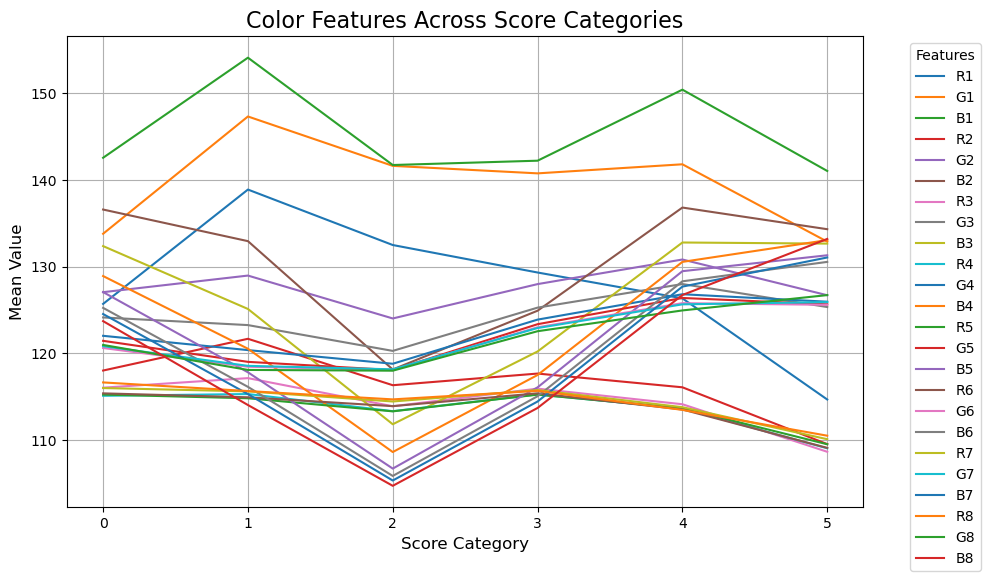

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for feature in color_features:
    plt.plot(df.index, df[feature], label=feature)

plt.title('Color Features Across Score Classes', fontsize=16)
plt.xlabel('Score Category', fontsize=12)
plt.ylabel('Mean Value', fontsize=12)
plt.legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Correlation between color features and score:
color_std      0.386203
Score Class    1.000000
Name: Score Class, dtype: float64


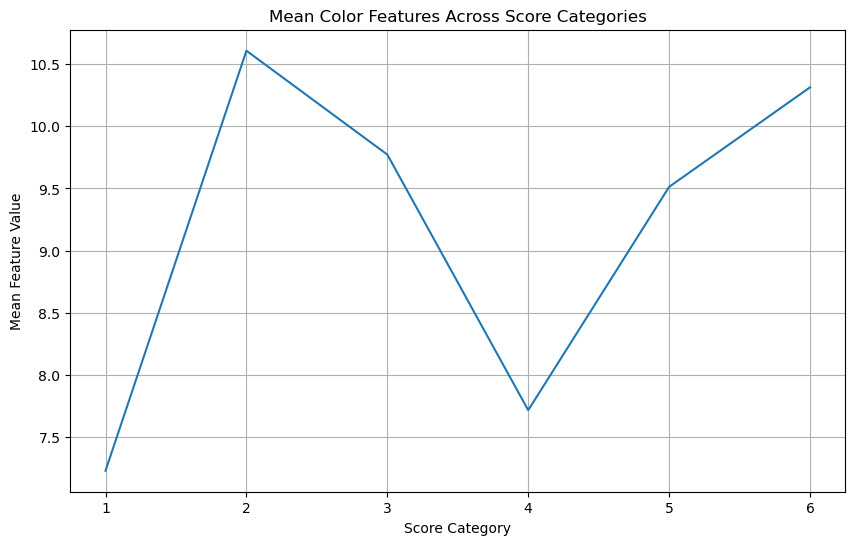

In [19]:
df['color_std'] = df[['R1', 'G1', 'B1', 'R2', 'G2', 'B2', 'R3', 'G3', 'B3', 'R4', 'G4', 'B4', 'R5', 'G5', 'B5', 'R6', 'G6', 'B6', 'R7', 'G7', 'B7', 'R8', 'G8', 'B8']].std(axis=1)

color_features_2 = ['color_std', 'Score Class']

correlation_matrix = df[color_features_2].corr()
print("Correlation between color features and score:")
print(correlation_matrix['Score Class'])

mean_colors_by_category_2 = df.groupby('Score Class')['color_std'].mean()

mean_colors_by_category_2.plot(kind='line', figsize=(10, 6))
plt.title('Mean Color Features Across Score Classes')
plt.xlabel('Score Category')
plt.ylabel('Mean Feature Value')
plt.grid(True)
# plt.savefig(f"/home/ubuntu/landscape-aesthetics/reports/figures/Mean Color Features Across Score Categories.jpg")
plt.show()

In [20]:
df.head(5)

,Score Class,R1,G1,B1,R2,G2,B2,R3,G3,B3,...,R6,G6,B6,R7,G7,B7,R8,G8,B8,color_std
0,1,125.714085,133.799794,142.561357,118.032206,127.065793,136.592249,116.056526,124.152050,132.377276,...,115.400302,120.629056,125.255570,116.014460,120.838683,124.545363,116.661569,120.983809,123.726486,7.230076
1,2,138.894953,147.320138,154.098392,121.691850,128.979923,132.948496,117.156206,123.271072,125.130425,...,114.946793,118.470475,116.150093,115.628369,118.572058,115.317693,115.667321,118.101775,114.055128,10.607599
2,3,132.501653,141.626943,141.725148,116.339153,124.035732,118.153284,113.914202,120.295880,111.838853,...,113.926881,118.096985,105.882382,114.463880,118.170857,105.353943,114.706415,118.015226,104.742282,9.772315
3,4,129.332565,140.763201,142.223334,117.683028,127.996141,124.929666,115.945171,125.284659,120.230379,...,115.408518,123.018477,115.071359,115.783744,122.933315,114.461622,115.688683,122.565458,113.718888,7.716845
4,5,126.352949,141.808322,150.411827,116.099551,130.831596,136.820427,114.145970,128.002066,132.792150,...,113.542981,125.799025,128.318409,113.806127,125.662933,127.706382,113.495465,124.962071,126.736951,9.513069


In [2]:
def ciede2000(lab1, lab2):
    L1, a1, b1 = lab1
    L2, a2, b2 = lab2

    avg_L = (L1 + L2) / 2
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    avg_C = (C1 + C2) / 2

    G = 0.5 * (1 - math.sqrt((avg_C**7) / (avg_C**7 + 25**7)))
    a1_prime = (1 + G) * a1
    a2_prime = (1 + G) * a2
    C1_prime = math.sqrt(a1_prime**2 + b1**2)
    C2_prime = math.sqrt(a2_prime**2 + b2**2)
    avg_C_prime = (C1_prime + C2_prime) / 2

    h1_prime = math.atan2(b1, a1_prime)
    if h1_prime < 0:
        h1_prime += 2 * math.pi
    h2_prime = math.atan2(b2, a2_prime)
    if h2_prime < 0:
        h2_prime += 2 * math.pi

    delta_L_prime = L2 - L1
    delta_C_prime = C2_prime - C1_prime

    if abs(h1_prime - h2_prime) <= math.pi:
        delta_h_prime = h2_prime - h1_prime
    else:
        if h2_prime <= h1_prime:
            delta_h_prime = h2_prime - h1_prime + 2 * math.pi
        else:
            delta_h_prime = h2_prime - h1_prime - 2 * math.pi

    delta_H_prime = 2 * math.sqrt(C1_prime * C2_prime) * math.sin(delta_h_prime / 2)

    avg_L_prime = (L1 + L2) / 2
    avg_C_prime = (C1_prime + C2_prime) / 2

    if abs(h1_prime - h2_prime) > math.pi:
        avg_H_prime = (h1_prime + h2_prime + 2 * math.pi) / 2
    else:
        avg_H_prime = (h1_prime + h2_prime) / 2

    T = (1 - 0.17 * math.cos(avg_H_prime - math.radians(30)) +
         0.24 * math.cos(2 * avg_H_prime) +
         0.32 * math.cos(3 * avg_H_prime + math.radians(6)) -
         0.20 * math.cos(4 * avg_H_prime - math.radians(63)))

    delta_theta = math.radians(30) * math.exp(-((avg_H_prime - math.radians(275)) / math.radians(25))**2)
    R_C = 2 * math.sqrt((avg_C_prime**7) / (avg_C_prime**7 + 25**7))
    S_L = 1 + (0.015 * (avg_L_prime - 50)**2) / math.sqrt(20 + (avg_L_prime - 50)**2)
    S_C = 1 + 0.045 * avg_C_prime
    S_H = 1 + 0.015 * avg_C_prime * T
    R_T = -math.sin(2 * delta_theta) * R_C

    delta_E = math.sqrt((delta_L_prime / S_L)**2 +
                        (delta_C_prime / S_C)**2 +
                        (delta_H_prime / S_H)**2 +
                        R_T * (delta_C_prime / S_C) * (delta_H_prime / S_H))

    return delta_E

In [5]:
import pandas as pd
import numpy as np
import colorspacious as cs
from itertools import combinations
import math

average_color_diffs = {}
for idx, row in df.iterrows():
    score_class = row['Score Class']
    
    colors = []
    for i in range(1, 9):
        r = row[f'R{i}']
        g = row[f'G{i}']
        b = row[f'B{i}']
        
        rgb_color = np.array([[r, g, b]]) / 255.0 
        lab_color = cs.cspace_convert(rgb_color, "sRGB1", "CIELab").flatten()
        colors.append(lab_color)
    
    color_diffs = []
    for color1, color2 in combinations(colors, 2):
        color_diff = ciede2000(color1, color2)
        color_diffs.append(color_diff)
    
    average_color_diffs[score_class] = np.mean(color_diffs)

for score_class, avg_diff in average_color_diffs.items():
    print(f"Score Class {score_class} 的平均色差 (CIEDE2000): {avg_diff}")

Score Class 1.0 的平均色差 (CIEDE2000): 2.5907871175897847
Score Class 2.0 的平均色差 (CIEDE2000): 4.624981376439571
Score Class 3.0 的平均色差 (CIEDE2000): 3.9466885223865718
Score Class 4.0 的平均色差 (CIEDE2000): 3.0792868105216895
Score Class 5.0 的平均色差 (CIEDE2000): 2.469621342864739
Score Class 6.0 的平均色差 (CIEDE2000): 1.2631083660751885


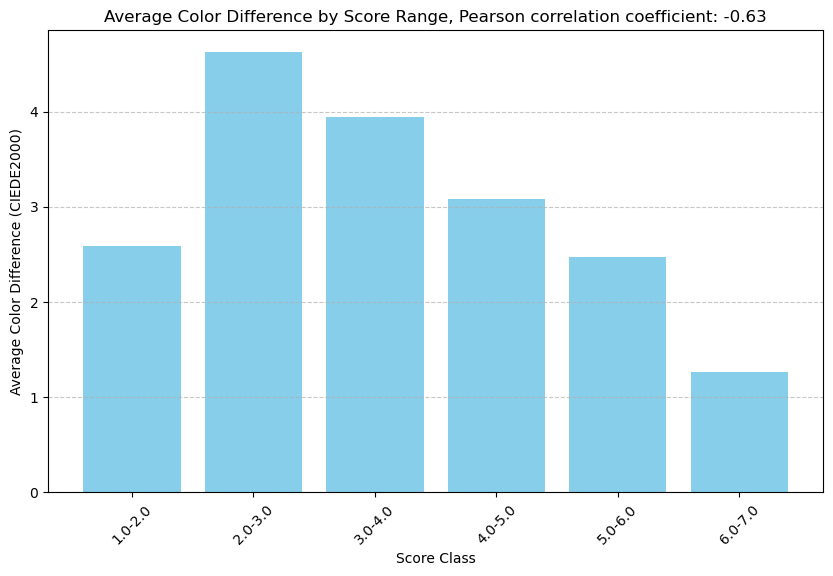

Pearson correlation coefficient between Score Class and Average Color Difference: -0.6308016482925154


In [13]:
import matplotlib.pyplot as plt
import pandas as pd

average_color_diffs_df = pd.DataFrame(list(average_color_diffs.items()), columns=['Score Class', 'Average Color Difference'])

average_color_diffs_df['Score Class'] = [f"{i}-{i+1}" for i in average_color_diffs_df['Score Class']]

correlation = average_color_diffs_df['Average Color Difference'].corr(pd.Series(range(1, len(average_color_diffs_df) + 1)))

plt.figure(figsize=(10, 6))
plt.bar(average_color_diffs_df['Score Class'], average_color_diffs_df['Average Color Difference'], color='skyblue')

plt.xlabel('Score Class')
plt.ylabel('Average Color Difference (CIEDE2000)')
plt.title(f"Average Color Difference by Score Range, Pearson correlation coefficient: {correlation:.2f}")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig("/home/ubuntu/landscape-aesthetics/reports/figures/color_difference_in_wikidata.jpg")
plt.show()

print(f"Pearson correlation coefficient between Score Class and Average Color Difference: {correlation}")
